<a href="https://colab.research.google.com/github/Collins-nnaji/Data_Science/blob/main/Project_4_NigeriaEndSarsTweets_SentimentAnalysis_TopicModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.7 MB/s eta 0:00:00


**A.Sentiment Analysis using BERT Model**

Step 1: Data Preprocessing

In [ ]:
import pandas as pd
import re

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Nigeria_EndSars_Tweets.csv')

# Rename a particular column
data = data.rename(columns={"content": "text"})

# Drop columns
columns_to_drop = ['id', 'username', 'outlinks', 'outlinksss', 'tcooutlinks','tcooutlinksss', 'url']
data = data.drop(columns=columns_to_drop)

data.head()

,Unnamed: 0,date,text
0,0,2021-04-22 18:28:26+00:00,This is the highest form of intimidation\nWhat...
1,1,2021-04-22 15:07:05+00:00,Why is it taking a life long time for @MBuhari...
2,2,2021-04-22 10:13:20+00:00,"Even Desmond Elliot is quite , ,,, what is tha..."
3,3,2021-04-22 09:48:04+00:00,When will CBN freeze the account of @DrIsaPant...
4,4,2021-04-22 09:31:40+00:00,@Obiejazzyup @YeleSowore @MBuhari @EndSars @mb...


In [ ]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text) # Remove URLs
    text = re.sub(r'@\w+', '', text) # Remove mentions
    text = re.sub(r'[^\w\s]', '', text) # Remove special characters and numbers
    return text

# Clean the text data in the tweets
data['cleaned_text'] = data['text'].apply(clean_text)


data.head()

,Unnamed: 0,date,text,cleaned_text
0,0,2021-04-22 18:28:26+00:00,This is the highest form of intimidation\nWhat...,This is the highest form of intimidation\nWhat...
1,1,2021-04-22 15:07:05+00:00,Why is it taking a life long time for @MBuhari...,Why is it taking a life long time for to sack...
2,2,2021-04-22 10:13:20+00:00,"Even Desmond Elliot is quite , ,,, what is tha...",Even Desmond Elliot is quite what is that wo...
3,3,2021-04-22 09:48:04+00:00,When will CBN freeze the account of @DrIsaPant...,When will CBN freeze the account of CBN was...
4,4,2021-04-22 09:31:40+00:00,@Obiejazzyup @YeleSowore @MBuhari @EndSars @mb...,okay that is good one but the ESN should ...


Step 2: BERT Model Preparation

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


Step 3: Sentiment Classification

In [ ]:
# Function to classify sentiment as numerical values
def classify_sentiment(text):
    result = sentiment_pipeline(text)
    if result[0]['label'] == 'POSITIVE':
        return result[0]['score']
    else:
        return -result[0]['score']

# Classify sentiment for each cleaned tweet and assign numerical values
data['sentiment_score'] = data['cleaned_text'].apply(classify_sentiment)


In [ ]:
data.head(5)

,Unnamed: 0,date,text,cleaned_text,sentiment_score
0,0,2021-04-22 18:28:26+00:00,This is the highest form of intimidation\nWhat...,This is the highest form of intimidation\nWhat...,-0.587088
1,1,2021-04-22 15:07:05+00:00,Why is it taking a life long time for @MBuhari...,Why is it taking a life long time for to sack...,-0.592527
2,2,2021-04-22 10:13:20+00:00,"Even Desmond Elliot is quite , ,,, what is tha...",Even Desmond Elliot is quite what is that wo...,-0.586219
3,3,2021-04-22 09:48:04+00:00,When will CBN freeze the account of @DrIsaPant...,When will CBN freeze the account of CBN was...,-0.573432
4,4,2021-04-22 09:31:40+00:00,@Obiejazzyup @YeleSowore @MBuhari @EndSars @mb...,okay that is good one but the ESN should ...,-0.566844


**B.Topic Modeling using LDA**

Step 1: Data Preprocessing



In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.lower() not in stop_words]
    return tokens

# Preprocess the cleaned tweets
data['preprocessed_text'] = data['cleaned_text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
data.head(5)

,Unnamed: 0,date,text,cleaned_text,sentiment_score,preprocessed_text
0,0,2021-04-22 18:28:26+00:00,This is the highest form of intimidation\nWhat...,This is the highest form of intimidation\nWhat...,-0.587088,"[highest, form, intimidation, offence, commit,..."
1,1,2021-04-22 15:07:05+00:00,Why is it taking a life long time for @MBuhari...,Why is it taking a life long time for to sack...,-0.592527,"[taking, life, long, time, sack, strong, proof..."
2,2,2021-04-22 10:13:20+00:00,"Even Desmond Elliot is quite , ,,, what is tha...",Even Desmond Elliot is quite what is that wo...,-0.586219,"[even, desmond, elliot, quite, woman, name, lo..."
3,3,2021-04-22 09:48:04+00:00,When will CBN freeze the account of @DrIsaPant...,When will CBN freeze the account of CBN was...,-0.573432,"[cbn, freeze, account, cbn, quick, freeze, acc..."
4,4,2021-04-22 09:31:40+00:00,@Obiejazzyup @YeleSowore @MBuhari @EndSars @mb...,okay that is good one but the ESN should ...,-0.566844,"[okay, good, one, esn, well, coordinated, work..."


Step 2: LDA Model Preparation

In [ ]:
import gensim
from gensim import corpora
import pandas as pd
import numpy as np
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')



# Tokenize and remove stopwords
stop_words = set(stopwords.words('english'))
data['tokens'] = data['cleaned_text'].apply(lambda x: [word for word in word_tokenize(x.lower()) if word.isalpha() and word not in stop_words])

# Create a dictionary and corpus for LDA
dictionary = Dictionary(data['tokens'])
corpus = [dictionary.doc2bow(text) for text in data['tokens']]

# Train the LDA model
num_topics = 5
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)

# Print topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}\n")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic: 0 
Words: 0.017*"u" + 0.016*"us" + 0.014*"go" + 0.013*"dey" + 0.013*"na" + 0.012*"need" + 0.011*"people" + 0.010*"nigeria" + 0.010*"one" + 0.008*"like"

Topic: 1 
Words: 0.009*"block" + 0.007*"house" + 0.007*"get" + 0.007*"mtn" + 0.005*"yahoo" + 0.005*"shame" + 0.005*"well" + 0.004*"nigeria" + 0.004*"wont" + 0.004*"country"

Topic: 2 
Words: 0.082*"endsars" + 0.021*"god" + 0.014*"sars" + 0.012*"bless" + 0.011*"endpolicebrutality" + 0.010*"endsarsnow" + 0.006*"police" + 0.005*"us" + 0.005*"want" + 0.005*"anymore"

Topic: 3 
Words: 0.016*"people" + 0.012*"protest" + 0.012*"government" + 0.011*"nigeria" + 0.011*"sars" + 0.009*"nigerian" + 0.008*"killing" + 0.008*"youths" + 0.008*"us" + 0.008*"u"

Topic: 4 
Words: 0.014*"nigeria" + 0.013*"police" + 0.011*"sars" + 0.009*"end" + 0.009*"sir" + 0.008*"dont" + 0.007*"brutality" + 0.007*"please" + 0.006*"youth" + 0.006*"reform"



In [ ]:
data.head()

,Unnamed: 0,date,text,cleaned_text,sentiment_score,preprocessed_text
0,0,2021-04-22 18:28:26+00:00,This is the highest form of intimidation\nWhat...,This is the highest form of intimidation\nWhat...,-0.587088,"[highest, form, intimidation, offence, commit,..."
1,1,2021-04-22 15:07:05+00:00,Why is it taking a life long time for @MBuhari...,Why is it taking a life long time for to sack...,-0.592527,"[taking, life, long, time, sack, strong, proof..."
2,2,2021-04-22 10:13:20+00:00,"Even Desmond Elliot is quite , ,,, what is tha...",Even Desmond Elliot is quite what is that wo...,-0.586219,"[even, desmond, elliot, quite, woman, name, lo..."
3,3,2021-04-22 09:48:04+00:00,When will CBN freeze the account of @DrIsaPant...,When will CBN freeze the account of CBN was...,-0.573432,"[cbn, freeze, account, cbn, quick, freeze, acc..."
4,4,2021-04-22 09:31:40+00:00,@Obiejazzyup @YeleSowore @MBuhari @EndSars @mb...,okay that is good one but the ESN should ...,-0.566844,"[okay, good, one, esn, well, coordinated, work..."


In [ ]:
# Assigning topic labels to each tweet:
def get_dominant_topic(doc_bow):
    topic_scores = lda_model[doc_bow]
    dominant_topic = sorted(topic_scores, key=lambda x: x[1], reverse=True)[0][0]
    return dominant_topic

data['dominant_topic'] = data['tokens'].apply(lambda x: get_dominant_topic(dictionary.doc2bow(x)))

In [ ]:
data.head()

,Unnamed: 0,date,text,cleaned_text,sentiment_score,preprocessed_text,tokens,dominant_topic
0,0,2021-04-22 18:28:26+00:00,This is the highest form of intimidation\nWhat...,This is the highest form of intimidation\nWhat...,-0.587088,"[highest, form, intimidation, offence, commit,...","[highest, form, intimidation, offence, commit,...",3
1,1,2021-04-22 15:07:05+00:00,Why is it taking a life long time for @MBuhari...,Why is it taking a life long time for to sack...,-0.592527,"[taking, life, long, time, sack, strong, proof...","[taking, life, long, time, sack, strong, proof...",0
2,2,2021-04-22 10:13:20+00:00,"Even Desmond Elliot is quite , ,,, what is tha...",Even Desmond Elliot is quite what is that wo...,-0.586219,"[even, desmond, elliot, quite, woman, name, lo...","[even, desmond, elliot, quite, womans, name, l...",3
3,3,2021-04-22 09:48:04+00:00,When will CBN freeze the account of @DrIsaPant...,When will CBN freeze the account of CBN was...,-0.573432,"[cbn, freeze, account, cbn, quick, freeze, acc...","[cbn, freeze, account, cbn, quick, freeze, acc...",2
4,4,2021-04-22 09:31:40+00:00,@Obiejazzyup @YeleSowore @MBuhari @EndSars @mb...,okay that is good one but the ESN should ...,-0.566844,"[okay, good, one, esn, well, coordinated, work...","[okay, good, one, esn, well, coordinated, work...",2


In [ ]:
#Evaluating the model using metrics like coherence score:
from gensim.models.coherencemodel import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=data['tokens'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('Coherence Score:', coherence_lda)

Coherence Score: 0.45412788276735183


In [ ]:
data.head()

,Unnamed: 0,date,text,cleaned_text,sentiment_score,preprocessed_text,tokens,dominant_topic
0,0,2021-04-22 18:28:26+00:00,This is the highest form of intimidation\nWhat...,This is the highest form of intimidation\nWhat...,-0.587088,"[highest, form, intimidation, offence, commit,...","[highest, form, intimidation, offence, commit,...",3
1,1,2021-04-22 15:07:05+00:00,Why is it taking a life long time for @MBuhari...,Why is it taking a life long time for to sack...,-0.592527,"[taking, life, long, time, sack, strong, proof...","[taking, life, long, time, sack, strong, proof...",0
2,2,2021-04-22 10:13:20+00:00,"Even Desmond Elliot is quite , ,,, what is tha...",Even Desmond Elliot is quite what is that wo...,-0.586219,"[even, desmond, elliot, quite, woman, name, lo...","[even, desmond, elliot, quite, womans, name, l...",3
3,3,2021-04-22 09:48:04+00:00,When will CBN freeze the account of @DrIsaPant...,When will CBN freeze the account of CBN was...,-0.573432,"[cbn, freeze, account, cbn, quick, freeze, acc...","[cbn, freeze, account, cbn, quick, freeze, acc...",2
4,4,2021-04-22 09:31:40+00:00,@Obiejazzyup @YeleSowore @MBuhari @EndSars @mb...,okay that is good one but the ESN should ...,-0.566844,"[okay, good, one, esn, well, coordinated, work...","[okay, good, one, esn, well, coordinated, work...",2


In [ ]:
# Visualizing the topics and their keywords using the pyLDAvis library:
!pip install pyLDAvis
!pip install numpy==1.22.4 pandas==1.5.3

import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 37.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.1 requires numpy>=1.24.2, but you have numpy 1.22.4 which is incompatible.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.127987  0.012933       1        1  29.309583
0     -0.106750  0.092059       2        1  26.351625
4     -0.055068  0.011304       3        1  17.995571
2      0.061171 -0.231063       4        1  14.920745
1      0.228633  0.114766       5        1  11.422477, topic_info=        Term        Freq       Total Category  logprob  loglift
175  endsars  968.000000  968.000000  Default  30.0000  30.0000
225      god  324.000000  324.000000  Default  29.0000  29.0000
445       na  271.000000  271.000000  Default  28.0000  28.0000
153   people  622.000000  622.000000  Default  27.0000  27.0000
426      dey  285.000000  285.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
23      time   26.192824  231.264225   Topic5  -5.8462  -0.0085
247    youre   22.890511   88.568234   Topic5  -5.9810   0.8165
935     keep   23.368441  126.619316   Topic5  -5.9603   0.4798
74       one   25.381137  403.408610   Topic5  -5.8777  -0.5964
433      see   24.379030  306.822635   Topic5  -5.9180  -0.3630

[337 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
761       1  0.084742     abeg
761       2  0.847416     abeg
761       3  0.067793     abeg
8         2  0.888585  account
8         3  0.070523  account
...     ...       ...      ...
1278      4  0.180325    youth
605       1  0.740500   youths
605       2  0.182022   youths
605       4  0.070327   youths
605       5  0.008274   youths

[547 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 3, 2])

**C.Data Visualizations**

Step 1: Data Preprocessing



In [ ]:
# Assume 'timestamp' is the name of the column containing tweet timestamps
data['date'] = pd.to_datetime(data['date']).dt.date
tweet_frequency = data['date'].value_counts().sort_index()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,date,text,cleaned_text,sentiment_score,preprocessed_text,tokens,dominant_topic
0,0,2021-04-22,This is the highest form of intimidation\nWhat...,This is the highest form of intimidation\nWhat...,-0.587088,"[highest, form, intimidation, offence, commit,...","[highest, form, intimidation, offence, commit,...",3
1,1,2021-04-22,Why is it taking a life long time for @MBuhari...,Why is it taking a life long time for to sack...,-0.592527,"[taking, life, long, time, sack, strong, proof...","[taking, life, long, time, sack, strong, proof...",0
2,2,2021-04-22,"Even Desmond Elliot is quite , ,,, what is tha...",Even Desmond Elliot is quite what is that wo...,-0.586219,"[even, desmond, elliot, quite, woman, name, lo...","[even, desmond, elliot, quite, womans, name, l...",3
3,3,2021-04-22,When will CBN freeze the account of @DrIsaPant...,When will CBN freeze the account of CBN was...,-0.573432,"[cbn, freeze, account, cbn, quick, freeze, acc...","[cbn, freeze, account, cbn, quick, freeze, acc...",2
4,4,2021-04-22,@Obiejazzyup @YeleSowore @MBuhari @EndSars @mb...,okay that is good one but the ESN should ...,-0.566844,"[okay, good, one, esn, well, coordinated, work...","[okay, good, one, esn, well, coordinated, work...",2


**Line chart for tweet frequencies**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-19-1af35e37a064>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tweet_frequency.index, rotation=45, ha='right')


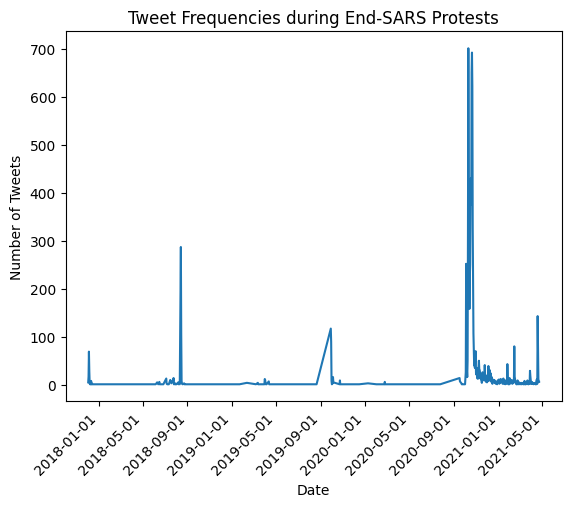

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots()

# Plot the tweet frequency
ax.plot(tweet_frequency.index, tweet_frequency.values)

# Set the x-axis labels with a slant
ax.set_xticklabels(tweet_frequency.index, rotation=45, ha='right')

# Set the x-axis major formatter to display dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets')
ax.set_title('Tweet Frequencies during End-SARS Protests')

# Display the plot
plt.show()


**Bar Chart for Sentiment Distribution**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


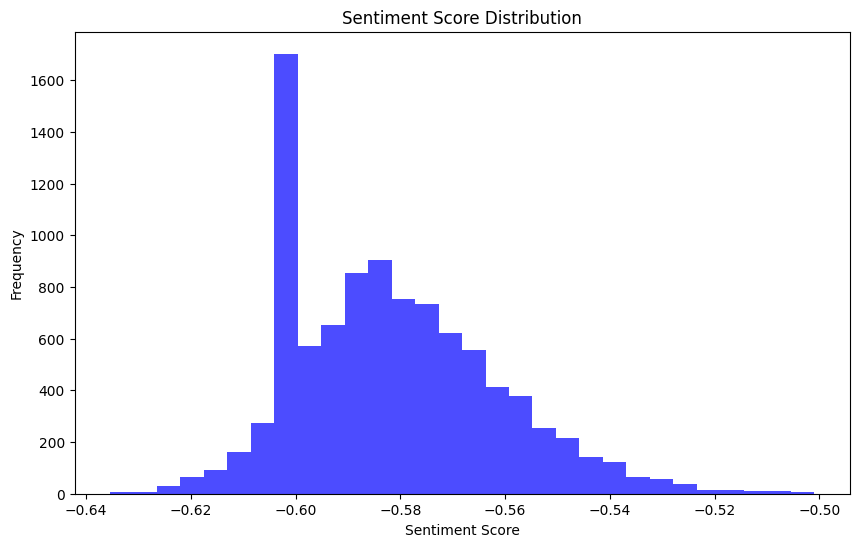

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(data['sentiment_score'], bins=30, color='blue', alpha=0.7)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Score Distribution')
plt.show()


**Word Cloud for Frequent Words**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:508:

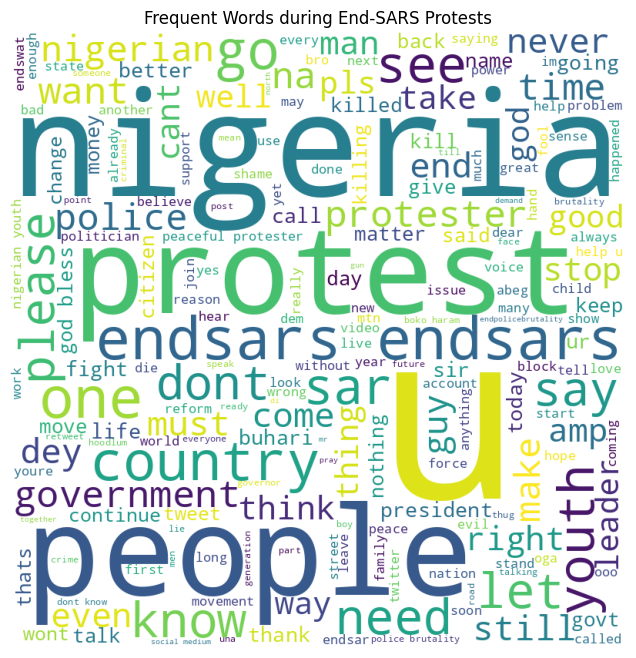

In [ ]:
from wordcloud import WordCloud

# Combine all preprocessed tweets into a single text
all_tweets = ' '.join([' '.join(tweet) for tweet in data['preprocessed_text']])

# Generate word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(all_tweets)

# Display word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Frequent Words during End-SARS Protests')
plt.show()


**Pie Chart for Sentiment Proportions**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


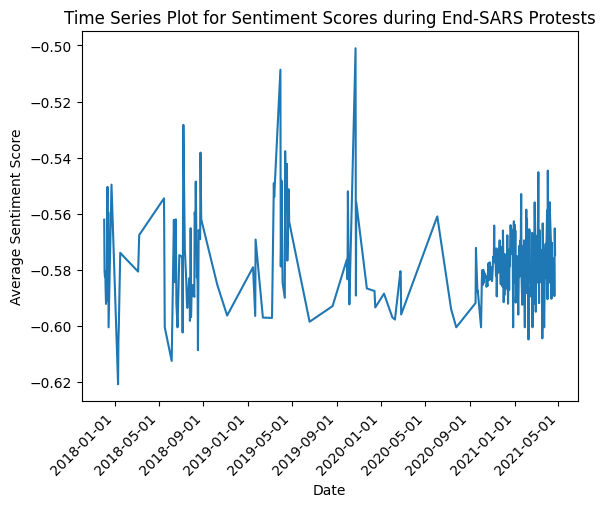

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming the dataset is already loaded as 'data' and sentiment scores are stored in the 'sentiment_score' column
# If not, load the dataset and perform sentiment analysis as previously described

# Convert the 'date' column to datetime format, if it's not already
data['date'] = pd.to_datetime(data['date'])

# Calculate average sentiment scores by date
sentiment_scores_by_date = data.groupby('date')['sentiment_score'].mean()

# Create the plot
fig, ax = plt.subplots()
ax.plot(sentiment_scores_by_date.index, sentiment_scores_by_date.values)

# Format the x-axis (date) labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Set axis labels and title
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.title('Time Series Plot for Sentiment Scores during End-SARS Protests')

# Show the plot
plt.show()



**Histogram of tweet length**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


count    9737.000000
mean      135.302249
std        89.966321
min         8.000000
25%        60.000000
50%       111.000000
75%       201.000000
max       536.000000
Name: text, dtype: float64


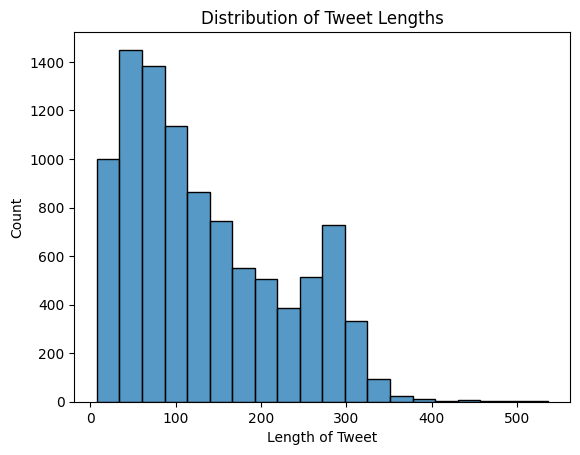

In [ ]:
# Print the distribution of tweet lengths
import seaborn as sns
tweet_lengths = data['text'].apply(len)
print(tweet_lengths.describe())

# Plot a histogram of tweet lengths
sns.histplot(tweet_lengths, bins=20)
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Length of Tweet")
plt.ylabel("Count")
plt.show()

**Descriptive statistics for sentiment score**

In [ ]:
import pandas as pd

# Assuming the dataset is already loaded as 'data' and sentiment scores are stored in the 'sentiment_score' column
# If not, load the dataset and perform sentiment analysis as previously described

# Calculate descriptive statistics
mean_sentiment = data['sentiment_score'].mean()
median_sentiment = data['sentiment_score'].median()
std_sentiment = data['sentiment_score'].std()
min_sentiment = data['sentiment_score'].min()
max_sentiment = data['sentiment_score'].max()

# Print the results
print(f"Mean sentiment: {mean_sentiment:.2f}")
print(f"Median sentiment: {median_sentiment:.2f}")
print(f"Standard deviation: {std_sentiment:.2f}")
print(f"Minimum sentiment: {min_sentiment:.2f}")
print(f"Maximum sentiment: {max_sentiment:.2f}")

# Calculate the percentage of positive, negative, and neutral sentiment
data['sentiment_label'] = data['sentiment_score'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))
sentiment_counts = data['sentiment_label'].value_counts(normalize=True) * 100

# Print the sentiment distribution
print("\nSentiment distribution:")
print(sentiment_counts)


Mean sentiment: -0.58
Median sentiment: -0.58
Standard deviation: 0.02
Minimum sentiment: -0.64
Maximum sentiment: -0.50

Sentiment distribution:
negative    100.0
Name: sentiment_label, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
